<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
lab3


Очищенные данные не найдены. Загрузка и очистка исходных данных...
Данные успешно загружены из URL.

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              10000 non-null  object 
 1   debts             10000 non-null  float64
 2   funeral_expenses  10000 non-null  float64
 3   bequests          10000 non-null  float64
 4   wife              10000 non-null  int64  
 5   husband           10000 non-null  int64  
 6   son               10000 non-null  int64  
 7   daughter          10000 non-null  int64  
 8   father            10000 non-null  int64  
 9   mother            10000 non-null  int64  
 10  brother           10000 non-null  int64  
 11  sister            10000 non-null  int64  
 12  grandchild        10000 non-null  int64  
dtypes: float64(3), int64(9), object(1)
memory usage: 1015.8+ KB


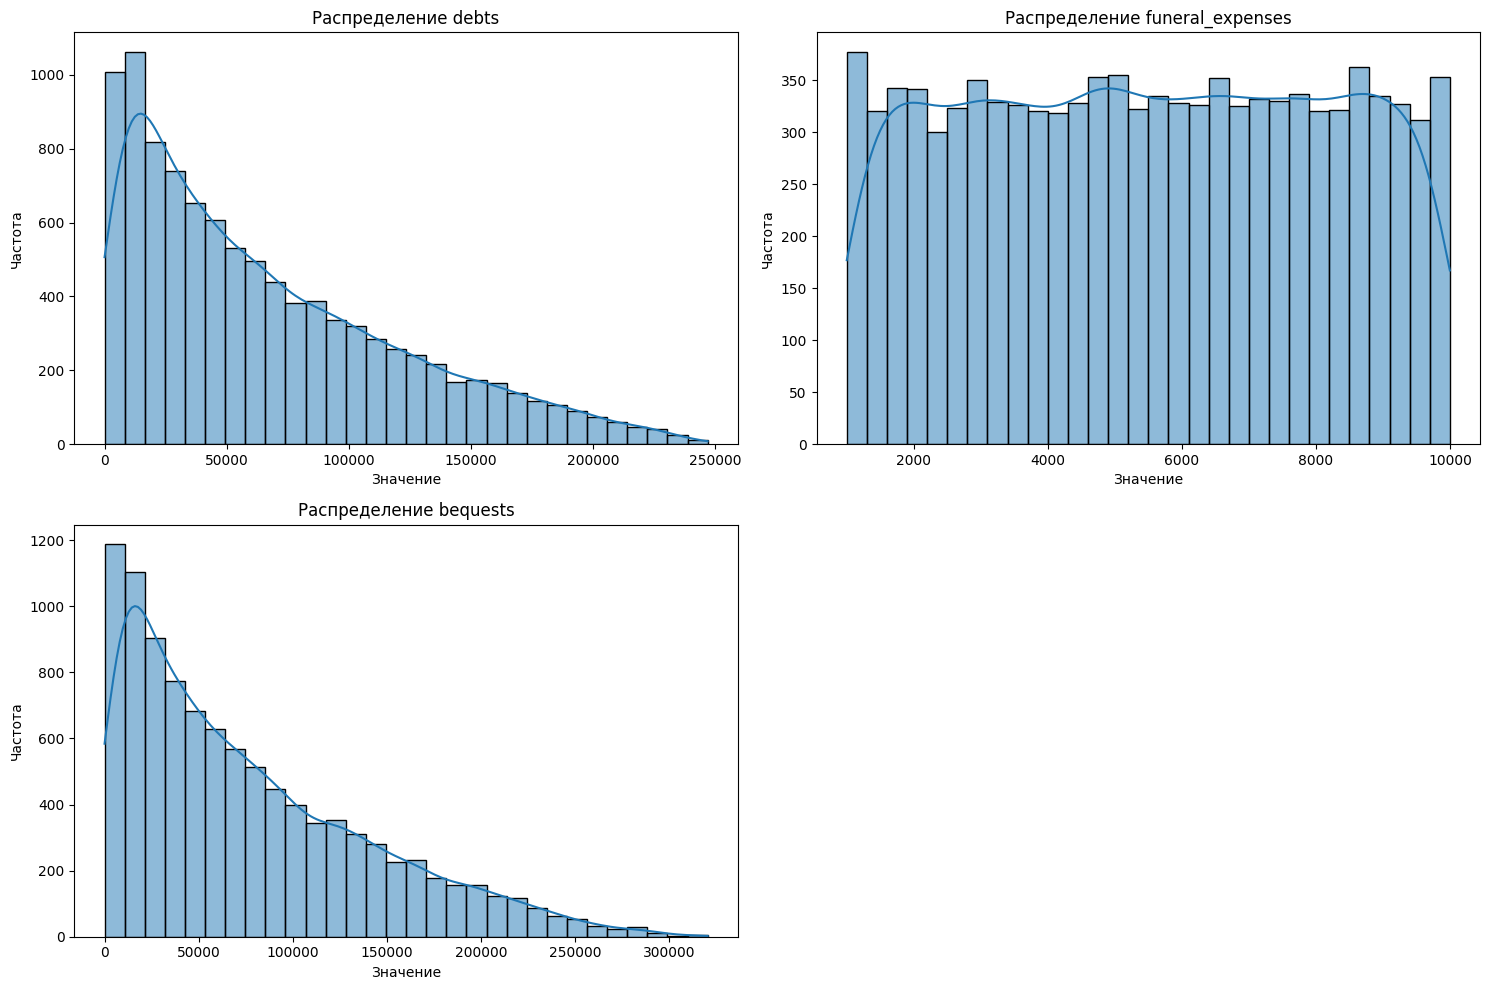

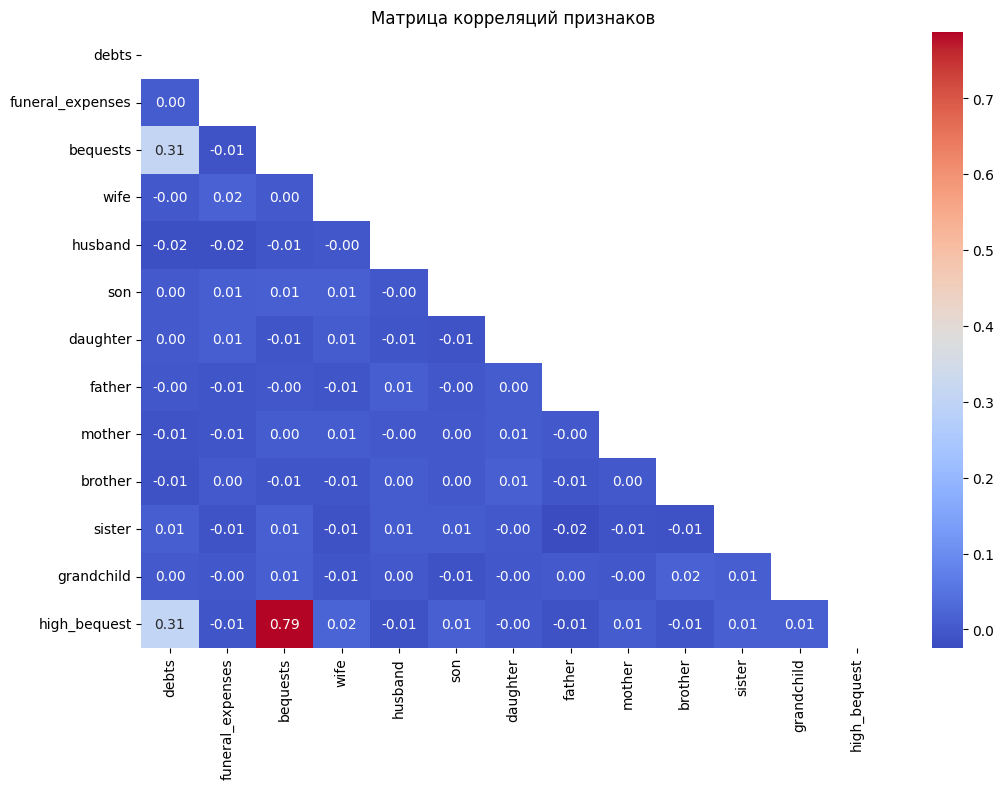

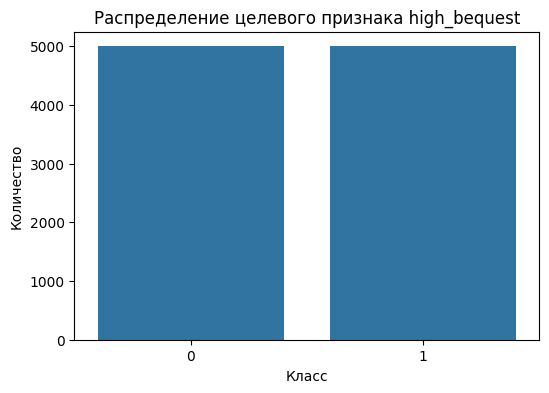


Баланс классов:
high_bequest
1    5000
0    5000
Name: count, dtype: int64

До SMOTE: Counter({0: 4000, 1: 4000})

KNN кросс-валидация F1-score: 0.5507 ± 0.0159
KNN обучена за 1.14 секунд

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.58      0.57      1000
           1       0.57      0.55      0.56      1000

    accuracy                           0.57      2000
   macro avg       0.57      0.57      0.57      2000
weighted avg       0.57      0.57      0.57      2000



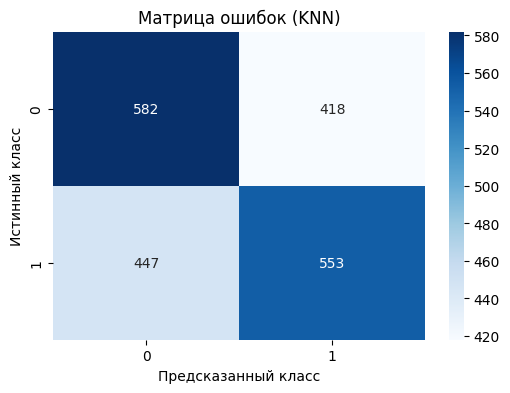

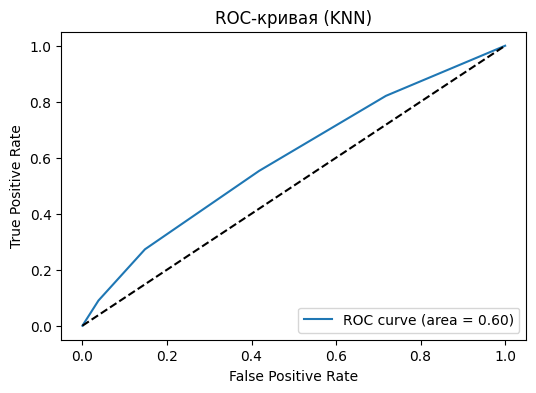


Random Forest кросс-валидация F1-score: 0.6243 ± 0.0096
Random Forest обучена за 8.26 секунд

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.61      0.62      1000
           1       0.62      0.64      0.63      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000



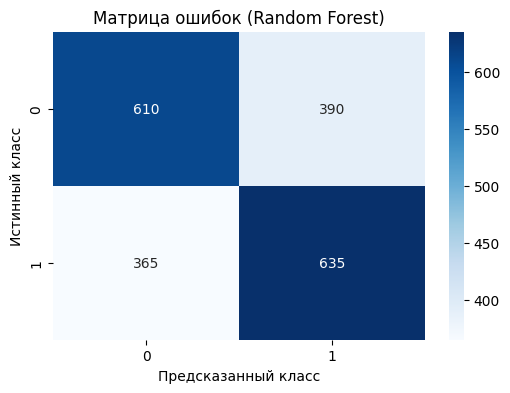

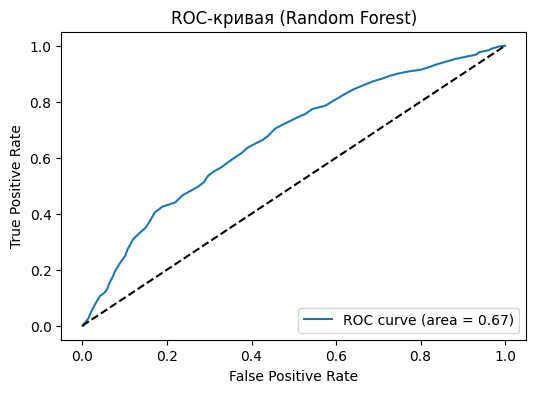


Лучшие параметры KNN: {'metric': 'euclidean', 'n_neighbors': 13, 'weights': 'uniform'}

KNN (optimized) Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.60      0.59      1000
           1       0.59      0.56      0.57      1000

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



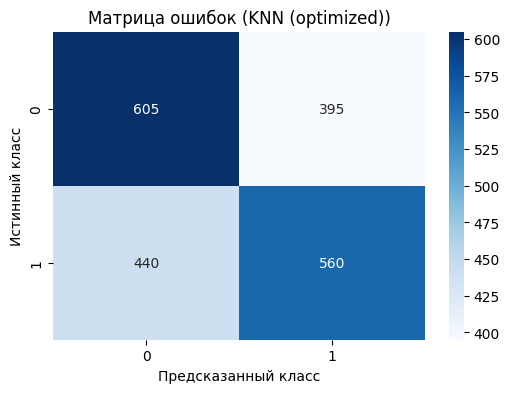

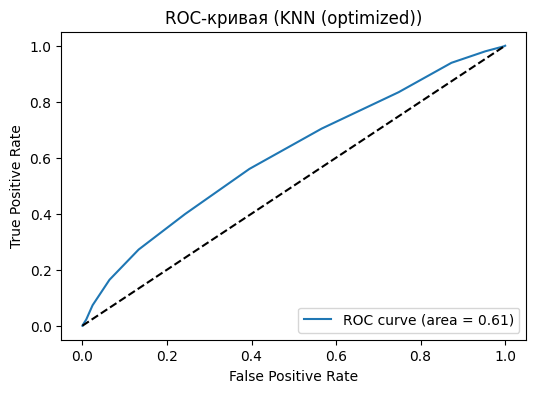

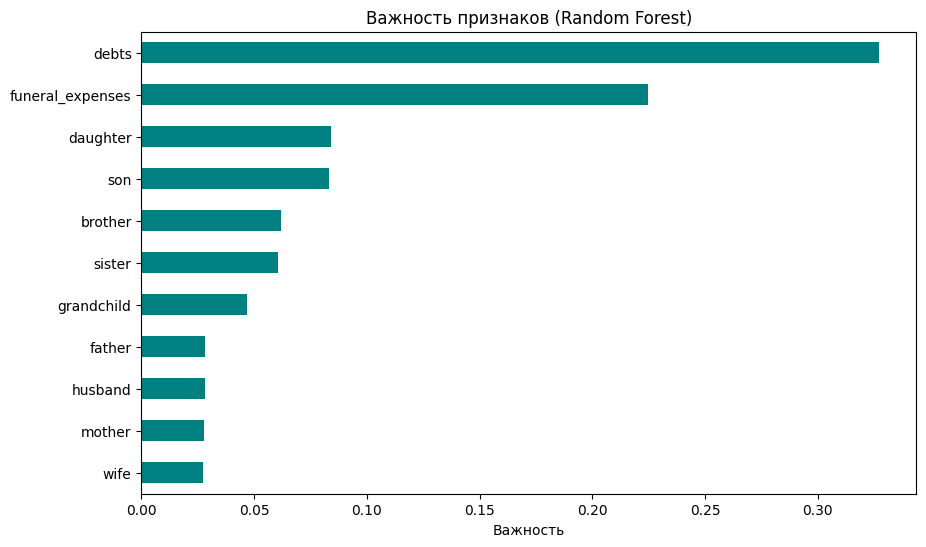

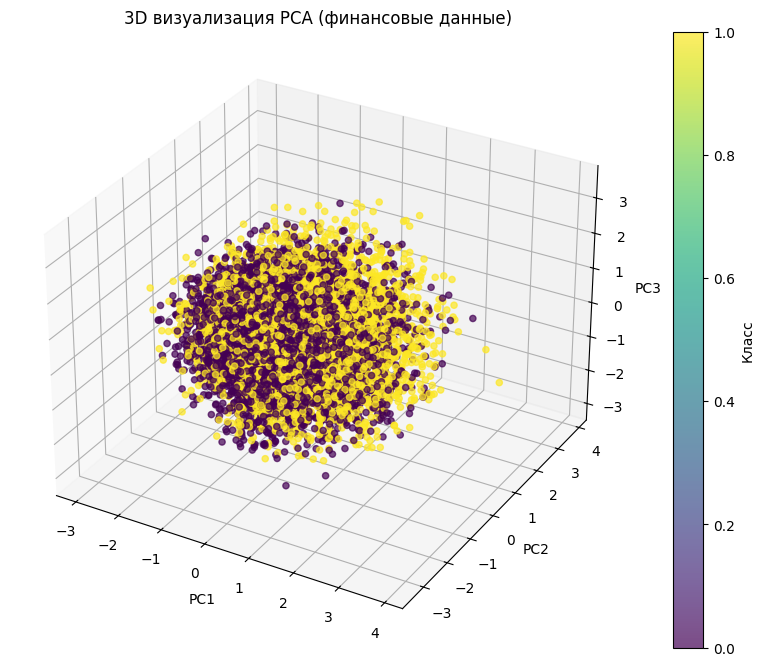

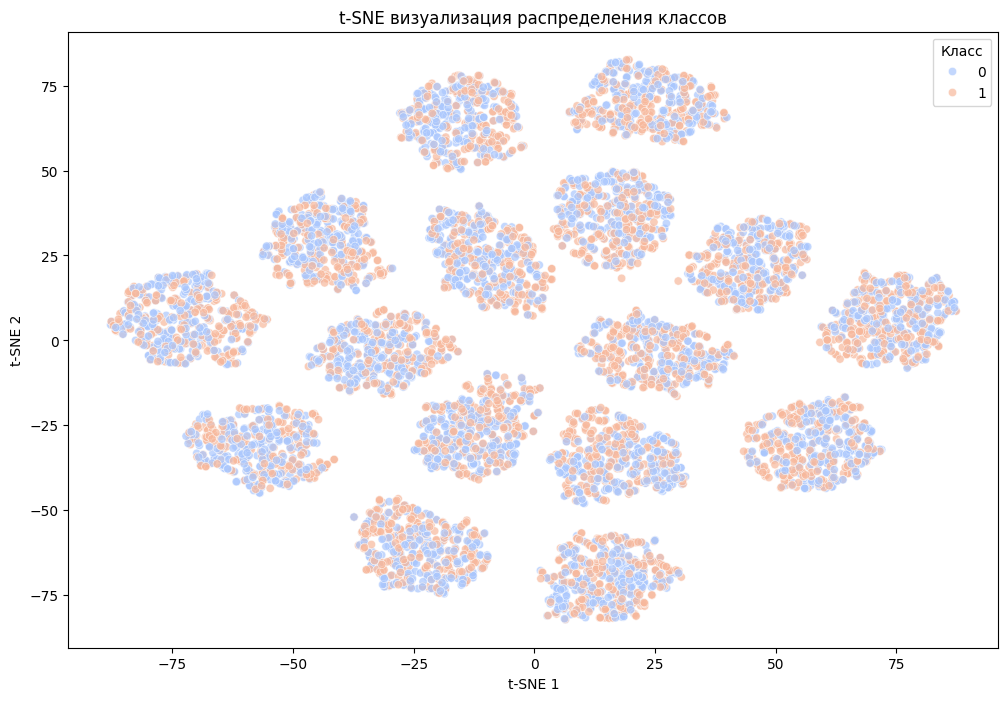

In [3]:
# --------------------------------------------------------------Лабораторная работа №3:


import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')


def load_data(url):
    try:
        df = pd.read_csv(url)
        print("Данные успешно загружены из URL.")
    except Exception as e:
        print(f"Ошибка загрузки данных: {e}")
        from google.colab import files
        uploaded = files.upload()
        df = pd.read_csv(next(iter(uploaded)))
        print("Данные успешно загружены из локального файла.")
    return df

url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/synthetic_inheritance_data.csv"
cleaned_data_path = "cleaned_data.csv"


if os.path.exists(cleaned_data_path):
    print("Загрузка очищенных данных из файла...")
    df_clean = pd.read_csv(cleaned_data_path)
else:
    print("Очищенные данные не найдены. Загрузка и очистка исходных данных...")
    df = load_data(url)

    print("\nИнформация о данных:")
    print(df.info())

    print("\nСтатистика по пропущенным значениям:")
    print(df.isnull().sum())

    print("\nКоличество дубликатов:", df.duplicated().sum())

    df = df.drop_duplicates()

    feature_columns = [
        'debts', 'funeral_expenses', 'bequests', 'wife', 'husband',
        'son', 'daughter', 'father', 'mother', 'brother', 'sister', 'grandchild'
    ]

    df_clean = df[feature_columns].dropna()

    median_bequest = df_clean['bequests'].median()
    df_clean['high_bequest'] = (df_clean['bequests'] >= median_bequest).astype(int)

    df_clean.to_csv(cleaned_data_path, index=False)
    print(f"Очищенные данные сохранены в {cleaned_data_path}")

print(f"\nРазмер данных после загрузки: {df_clean.shape}")

# Визуализация распределения некоторых признаков
def plot_histograms(df, columns):
    plt.figure(figsize=(15,10))
    for i, col in enumerate(columns, 1):
        plt.subplot(2, 2, i)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Распределение {col}')
        plt.xlabel('Значение')
        plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()

plot_histograms(df_clean, ['debts', 'funeral_expenses', 'bequests'])

# Корреляционная матрица
plt.figure(figsize=(12,8))
corr_matrix = df_clean.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Матрица корреляций признаков')
plt.show()

# Распределение целевого признака
plt.figure(figsize=(6,4))
sns.countplot(x='high_bequest', data=df_clean)
plt.title('Распределение целевого признака high_bequest')
plt.xlabel('Класс')
plt.ylabel('Количество')
plt.show()

class_counts = df_clean['high_bequest'].value_counts()
print(f"\nБаланс классов:\n{class_counts}")

# Подготовка данных для обучения
X = df_clean.drop(columns=['high_bequest', 'bequests'])
y = df_clean['high_bequest']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from collections import Counter
print(f"\nДо SMOTE: {Counter(y_train)}")
if min(class_counts) / max(class_counts) < 0.5:
    smote = SMOTE(random_state=42)
    X_train_scaled, y_train = smote.fit_resample(X_train_scaled, y_train)
    print(f"После SMOTE: {Counter(y_train)}")

# Функция оценки модели
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f'\n{model_name} Classification Report:')
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок ({model_name})')
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:,1]
    else:
        y_proba = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривая ({model_name})')
    plt.legend(loc='lower right')
    plt.show()

# Обучение и оценка моделей
models = {
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced')
}

for name, model in models.items():
    start_time = time.time()
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='f1')
    print(f"\n{name} кросс-валидация F1-score: {scores.mean():.4f} ± {scores.std():.4f}")

    model.fit(X_train_scaled, y_train)
    end_time = time.time()
    print(f"{name} обучена за {end_time - start_time:.2f} секунд")

    evaluate_model(model, X_test_scaled, y_test, name)

# Грид-серч для KNN
param_grid = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_
print(f'\nЛучшие параметры KNN: {grid_search.best_params_}')

evaluate_model(best_knn, X_test_scaled, y_test, "KNN (optimized)")

# Важность признаков (Random Forest)
forest = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
forest.fit(X_train_scaled, y_train)

feat_importances = pd.Series(forest.feature_importances_, index=X.columns)
feat_importances = feat_importances.sort_values(ascending=True)

plt.figure(figsize=(10,6))
feat_importances.plot(kind='barh', color='teal')
plt.title('Важность признаков (Random Forest)')
plt.xlabel('Важность')
plt.show()

# PCA 3D визуализация
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train_scaled)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y_train, cmap='viridis', alpha=0.7)
ax.set_title('3D визуализация PCA (финансовые данные)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter, label='Класс')
plt.show()

# t-SNE 2D визуализация
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne = tsne.fit_transform(X_train_scaled)

plt.figure(figsize=(12,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y_train, palette='coolwarm', alpha=0.7)
plt.title('t-SNE визуализация распределения классов')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend(title='Класс')
plt.show()
